# Install dependencies & Download dataset

In [8]:
import os
import subprocess
import sys

# 2. Check for NVIDIA driver
try:
    result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, check=True)
    output = result.stdout
except Exception:
    print("NVIDIA driver not found.")
    TORCH_TAG = "cpu"
else:
    # 3. Parse CUDA version from nvidia-smi output
    cuda_line = next((line for line in output.splitlines() if "CUDA Version" in line), None)
    if cuda_line:
        # cuda_version = cuda_line.split()[-1].strip()
        parts = cuda_line.split("CUDA Version:")
        cuda_version = parts[1].strip().split()[0] # first token after "CUDA Version:"
        print("Detected CUDA version:", cuda_version)
        major, minor = cuda_version.split(".")
        cuda_code = major + minor
        print("CUDA code:", cuda_code)

        # 4. Map CUDA code to torch tag
        mapping = {
            "118": "cu118",
            "119": "cu118",
            "120": "cu121",
            "121": "cu121",
            "122": "cu121",
            "123": "cu124",
            "124": "cu124",
            "125": "cu124",
            "126": "cu126",
            "127": "cu124",
            "128": "cu124",
            "129": "cu124",
            "130": "cu130",
        }
        TORCH_TAG = mapping.get(cuda_code, "cpu")
    else:
        TORCH_TAG = "cpu"

# 5. Install packages
if TORCH_TAG == "cpu":
    print("Installing CPU-only PyTorch...")
    %pip install numpy pandas matplotlib pillow torch torchvision scikit-learn seaborn requests
else:
    print(f"Installing PyTorch for {TORCH_TAG}...")
    %pip install numpy pandas matplotlib pillow torch torchvision scikit-learn seaborn requests --extra-index-url https://download.pytorch.org/whl/{TORCH_TAG}


Detected CUDA version: 13.0
CUDA code: 130
Installing PyTorch for cu130...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu130
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import requests

url = "https://media.githubusercontent.com/media/ImmortalZeus/IT3320E_IntroductionToDeepLearning_Group4/refs/heads/main/Dataset/fer2013.csv?download=true"
r = requests.get(url)
with open("fer2013.csv", "wb") as f:
    f.write(r.content)

print("Downloaded fer2013.csv")

Downloaded fer2013.csv


# Standard imports and environment setup

In [2]:
# Imports
# --- Standard library ---
import os
import time
import copy
import random
from pathlib import Path
from typing import Any, Dict, List, Tuple

# --- Third-party libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- PyTorch & torchvision ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
RND_SEED = 42
random.seed(RND_SEED)
np.random.seed(RND_SEED)
torch.manual_seed(RND_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

OUT_DIR = Path('cnn_practice_out')
OUT_DIR.mkdir(exist_ok=True)

Device: cuda


# Preparing data (Import + Normalize)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ----- Custom dataset for FER2013 -----
class FER2013Dataset(Dataset):
    def __init__(self, csv_path: str, usage: str = "Training", transform=None):
        df = pd.read_csv(csv_path)
        df = df[df["Usage"] == usage]      # "Training", "PublicTest", "PrivateTest"

        # pixels: "70 80 82 ..." -> (48, 48) uint8
        self.X = np.array([
            np.fromstring(pix, dtype=np.uint8, sep=" ").reshape(48, 48)
            for pix in df["pixels"]
        ])
        self.y = df["emotion"].values.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.fromarray(self.X[idx])  # grayscale PIL image
        if self.transform is not None:
            img = self.transform(img)
        label = self.y[idx]
        return img, label


# ----- Unified dataloader function -----
def get_dataloaders(
    dataset_name: str = 'FER2013',
    batch_size: int = 256,
    quick: bool = False,
    csv_path: str = "./fer2013.csv",  # path for FER2013
    use_augmentation: bool = False,
    for_transfer: bool = False,
):
    dataset_name = dataset_name.upper()
    
    interp_mode = transforms.InterpolationMode.BICUBIC

    if dataset_name == 'FER2013':
        if for_transfer:
            # --- transforms for pretrained models (ResNet, etc.) ---
            imagenet_mean = (0.485, 0.456, 0.406)
            imagenet_std  = (0.229, 0.224, 0.225)

            if use_augmentation:
                train_transforms = transforms.Compose([
                    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), interpolation=interp_mode), 
                    transforms.Grayscale(num_output_channels=3),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(imagenet_mean, imagenet_std),
                    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
                ])
            else:
                train_transforms = transforms.Compose([
                    transforms.Resize((224, 224), interpolation=interp_mode),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(),
                    transforms.Normalize(imagenet_mean, imagenet_std),
                ])

            val_test_transforms = transforms.Compose([
                transforms.Resize((224, 224), interpolation=interp_mode),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),

                transforms.Normalize(imagenet_mean, imagenet_std),
            ])
            
            train_set = FER2013Dataset(csv_path, usage="Training",   transform=train_transforms)
            val_set  = FER2013Dataset(csv_path, usage="PublicTest", transform=val_test_transforms)
            test_set  = FER2013Dataset(csv_path, usage="PrivateTest", transform=val_test_transforms)
            num_classes = 7

        else: # Simple grayscale normalization to [-1, 1]
            mean = (0.5,)
            std  = (0.5,)

            if use_augmentation:
                train_transforms = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(48, padding=4),           # small random shifts
                    transforms.RandomRotation(10),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                    # transforms.RandomErasing(p=0.2, scale=(0.02, 0.05)) 
                ])

            else:
                train_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])


            val_test_transforms = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

            train_set = FER2013Dataset(csv_path, usage="Training",   transform=train_transforms)
            val_set  = FER2013Dataset(csv_path, usage="PublicTest", transform=val_test_transforms)
            test_set  = FER2013Dataset(csv_path, usage="PrivateTest", transform=val_test_transforms)
            num_classes = 7

    else:
        raise ValueError('Unsupported dataset')

    # ----- quick mode: use a small subset -----
    if quick:
        # số lượng muốn lấy
        n_train = min(4000, len(train_set))
        n_val  = min(2000, len(val_set))
        n_test  = min(2000, len(test_set))
    
        # lấy label từ dataset gốc
        train_labels = [train_set[i][1] for i in range(len(train_set))]
        val_labels  = [val_set[i][1] for i in range(len(val_set))]
        test_labels  = [test_set[i][1] for i in range(len(test_set))]

        # stratified split cho train
        splitter_train = StratifiedShuffleSplit(n_splits=1, train_size=n_train, random_state=RND_SEED)
        train_idx, _ = next(splitter_train.split(range(len(train_set)), train_labels))

        # stratified split cho val
        splitter_val = StratifiedShuffleSplit(n_splits=1, train_size=n_val, random_state=RND_SEED)
        val_idx, _ = next(splitter_val.split(range(len(val_set)), val_labels))

        # stratified split cho test
        splitter_test = StratifiedShuffleSplit(n_splits=1, train_size=n_test, random_state=RND_SEED)
        test_idx, _ = next(splitter_test.split(range(len(test_set)), test_labels))

        # tạo subset
        train_set = Subset(train_set, train_idx)
        val_set = Subset(val_set, val_idx)
        test_set  = Subset(test_set, test_idx)
    
        # # Use first N samples
        # train_indices = list(range(min(2000, len(train_set))))
        # test_indices  = list(range(min(1000, len(test_set))))
        # train_set = Subset(train_set, train_indices)
        # test_set  = Subset(test_set, test_indices)

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
    )

    return train_loader, val_loader, test_loader, num_classes




In [4]:
class FinalFER2013CNN(nn.Module):
    def __init__(self, num_classes: int = 7, dropout_p: float = 0.1):
        super().__init__()
        self.dropout_p = dropout_p

        def norm_layer(channels: int):
            # fixed to BatchNorm for the final model
            return nn.BatchNorm2d(channels)

        # Block 1: 1x48x48 -> 32x24x24
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            # nn.Conv2d(3, 32, kernel_size=3, padding=1),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 48 -> 24
        )

        # Block 2: 32x24x24 -> 64x12x12
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            norm_layer(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            norm_layer(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 24 -> 12
        )

        # Block 3: 64x12x12 -> 128x6x6
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            norm_layer(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            norm_layer(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 12 -> 6
        )

        # Block 4: 128x6x6 -> 256x6x6 + Dropout2d
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            norm_layer(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_p)
        )

        # Global average pooling + linear head
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # global average pooling over H,W -> (B, 256)
        x = x.mean(dim=(2, 3))
        x = self.fc(x)
        return x


In [5]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion,
    optimizer,
    device: torch.device,
):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        _, preds = out.max(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return running_loss / total, correct / total


def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion,
    device: torch.device,
):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            out = model(xb)
            loss = criterion(out, yb)

            running_loss += loss.item() * xb.size(0)
            _, preds = out.max(1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

    return running_loss / total, correct / total

# 📌 Note

If you want to skip the training process and only run the evaluation, you can ignore the blocks below this note.  
**At the end of the notebook**, you will find two evaluation blocks (one for our CNN model and one for ResNet) that:

1. **Download our trained model weights from our GitHub**  
2. **Run evaluation on the test dataset** to produce accuracy, a classification report, and a confusion matrix

You can run these two blocks directly to reproduce the evaluation results without needing to train the model.  
All initialization above is just setup; the final blocks are self-contained for evaluation only.


# Default parameter

In [16]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"

    num_epochs  = 50
    batch_size  = 256
    lr          = 1e-3
    quick_debug = False  # set True to test quickly

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=0.1).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"time {time.time() - t0:.1f}s"
        )

    print(f"Best val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "cnn_fer2013_default_parameter.pth")
        print("Saved final model.")


Epoch 1/50 | train loss 1.6525 acc 0.3416 | val loss 1.9306 acc 0.3753 | time 14.4s
Epoch 2/50 | train loss 1.3491 acc 0.4856 | val loss 1.5691 acc 0.4096 | time 14.4s
Epoch 3/50 | train loss 1.2344 acc 0.5331 | val loss 1.3547 acc 0.4918 | time 14.3s
Epoch 4/50 | train loss 1.1708 acc 0.5571 | val loss 1.1662 acc 0.5545 | time 13.9s
Epoch 5/50 | train loss 1.1247 acc 0.5739 | val loss 1.3976 acc 0.5174 | time 14.3s
Epoch 6/50 | train loss 1.0898 acc 0.5878 | val loss 1.1711 acc 0.5642 | time 14.3s
Epoch 7/50 | train loss 1.0609 acc 0.6007 | val loss 1.1815 acc 0.5667 | time 14.3s
Epoch 8/50 | train loss 1.0418 acc 0.6053 | val loss 1.2105 acc 0.5592 | time 14.2s
Epoch 9/50 | train loss 1.0250 acc 0.6128 | val loss 1.1965 acc 0.5600 | time 14.3s
Epoch 10/50 | train loss 1.0009 acc 0.6209 | val loss 1.1093 acc 0.5971 | time 14.4s
Epoch 11/50 | train loss 0.9911 acc 0.6288 | val loss 1.0888 acc 0.6055 | time 14.3s
Epoch 12/50 | train loss 0.9798 acc 0.6303 | val loss 1.0805 acc 0.6063 | 

# Tuning phase

In [ ]:
def run_adam_dropout_experiment(
    exp_name: str,
    csv_path: str,
    lr: float,
    weight_decay: float,
    dropout_p: float,
    num_epochs: int = 30,
    batch_size: int = 256,
    quick: bool = False,
    verbose: bool = True,
):
    # dataloaders with augmentation ON
    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if verbose:
            print(
                f"[{exp_name}] Epoch {epoch}/{num_epochs} | "
                f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
                f"time {time.time() - t0:.1f}s"
            )

    result = {
        "exp_name": exp_name,
        "lr": lr,
        "weight_decay": weight_decay,
        "dropout_p": dropout_p,
        "num_epochs": num_epochs,
        "best_val_acc": best_val_acc,
        "history": history,
    }

    if best_state is not None:
        model.load_state_dict(best_state)
        out_path = OUT_DIR / f"{exp_name}_best.pth"
        torch.save(model.state_dict(), out_path)

    return result


def run_adamw_dropout_experiment(
    exp_name: str,
    csv_path: str,
    lr: float,
    weight_decay: float,
    dropout_p: float,
    num_epochs: int = 30,
    batch_size: int = 256,
    quick: bool = False,
    verbose: bool = True,
):
    # dataloaders with augmentation ON
    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if verbose:
            print(
                f"[{exp_name}] Epoch {epoch}/{num_epochs} | "
                f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
                f"time {time.time() - t0:.1f}s"
            )

    result = {
        "exp_name": exp_name,
        "lr": lr,
        "weight_decay": weight_decay,
        "dropout_p": dropout_p,
        "num_epochs": num_epochs,
        "best_val_acc": best_val_acc,
        "history": history,
    }

    if best_state is not None:
        model.load_state_dict(best_state)
        out_path = OUT_DIR / f"{exp_name}_best.pth"
        torch.save(model.state_dict(), out_path)

    return result


In [ ]:
def tune_adam_and_dropout(csv_path: str, quick: bool = True):
    lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    wds = [0.0, 2e-5, 1e-5, 1e-4]
    dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]

    num_epochs = 20 if quick else 40
    batch_size = 256

    all_results = []

    for p in dropouts:
        for lr in lrs:
            for wd in wds:
                exp_name = f"adam_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
                print("=" * 80)
                print(f"Running {exp_name}")
                res = run_adam_dropout_experiment(
                    exp_name=exp_name,
                    csv_path=csv_path,
                    lr=lr,
                    weight_decay=wd,
                    dropout_p=p,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    quick=quick,
                    verbose=True,
                )
                all_results.append(res)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:30]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_best_histories(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top Adam + Dropout configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running adam_lr_0.0001_weight_decay_0.0_drop_out_0.0
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 1/20 | train loss 1.9655 acc 0.1235 | val loss 1.9641 acc 0.1820 | time 2.1s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 2/20 | train loss 1.8971 acc 0.2357 | val loss 1.9218 acc 0.2150 | time 1.8s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 3/20 | train loss 1.8433 acc 0.2720 | val loss 1.8400 acc 0.2660 | time 1.8s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 4/20 | train loss 1.8075 acc 0.2818 | val loss 1.7930 acc 0.2660 | time 2.0s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 5/20 | train loss 1.7752 acc 0.2980 | val loss 1.7856 acc 0.2785 | time 2.0s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 6/20 | train loss 1.7469 acc 0.3085 | val loss 1.7450 acc 0.3170 | time 1.9s
[adam_lr_0.0001_weight_decay_0.0_drop_out_0.0] Epoch 7/20 | train loss 1.7155 acc 0.3242 | val loss 1.7056 acc 0.3100 | time 2.0s
[adam_lr_0.0001_weight_decay_0.0_drop

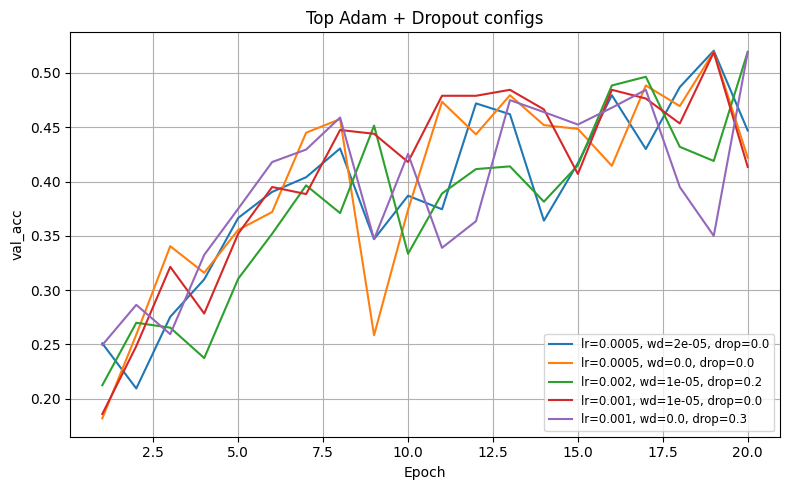

In [8]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adam_and_dropout(csv_path, quick=True)
    plot_best_histories(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


In [10]:
def tune_adam_and_dropout_phrase_2(csv_path: str, quick: bool = True):
    # lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    # wds = [0.0, 2e-5, 1e-5, 1e-4]
    # dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]
    lr_wd_dropout_combination = [
        {"lr": 5e-4, "wd": 2e-5, "dropout": 0.0},
        {"lr": 5e-4, "wd": 0.0, "dropout": 0.0},
        {"lr": 2e-3, "wd": 1e-5, "dropout": 0.2},
        {"lr": 1e-3, "wd": 1e-5, "dropout": 0.0},
        {"lr": 1e-3, "wd": 0.0, "dropout": 0.3},
        {"lr": 1e-3, "wd": 1e-5, "dropout": 0.1},
        {"lr": 2e-3, "wd": 2e-5, "dropout": 0.5},
        {"lr": 5e-4, "wd": 2e-5, "dropout": 0.1},
        {"lr": 5e-4, "wd": 2e-5, "dropout": 0.1},
        {"lr": 1e-3, "wd": 2e-5, "dropout": 0.3},
        {"lr": 1e-3, "wd": 1e-5, "dropout": 0.5},
        {"lr": 5e-4, "wd": 1e-5, "dropout": 0.3},
    ]

    num_epochs = 20 if quick else 40
    batch_size = 256

    all_results = []

    for combinations in lr_wd_dropout_combination:
        lr = combinations["lr"]
        wd = combinations["wd"]
        p = combinations["dropout"]
        exp_name = f"adam_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
        print("=" * 80)
        print(f"Running {exp_name}")
        res = run_adam_dropout_experiment(
            exp_name=exp_name,
            csv_path=csv_path,
            lr=lr,
            weight_decay=wd,
            dropout_p=p,
            num_epochs=num_epochs,
            batch_size=batch_size,
            quick=quick,
            verbose=True,
        )
        all_results.append(res)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_best_histories_phrase_2(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top Adam + Dropout configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 1/40 | train loss 1.6409 acc 0.3464 | val loss 1.5621 acc 0.3823 | time 12.0s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 2/40 | train loss 1.3783 acc 0.4754 | val loss 1.3362 acc 0.4826 | time 12.5s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 3/40 | train loss 1.2619 acc 0.5204 | val loss 1.4201 acc 0.4659 | time 12.8s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 4/40 | train loss 1.2001 acc 0.5468 | val loss 1.3568 acc 0.5040 | time 12.9s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 5/40 | train loss 1.1524 acc 0.5650 | val loss 1.2003 acc 0.5447 | time 13.1s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 6/40 | train loss 1.1169 acc 0.5770 | val loss 1.3136 acc 0.5160 | time 13.2s
[adam_lr_0.0005_weight_decay_2e-05_drop_out_0.0] Epoch 7/40 | train loss 1.0907 acc 0.5889 | val loss 1.2890 acc 0.5316 | time 12.8s
[adam_lr_0.000

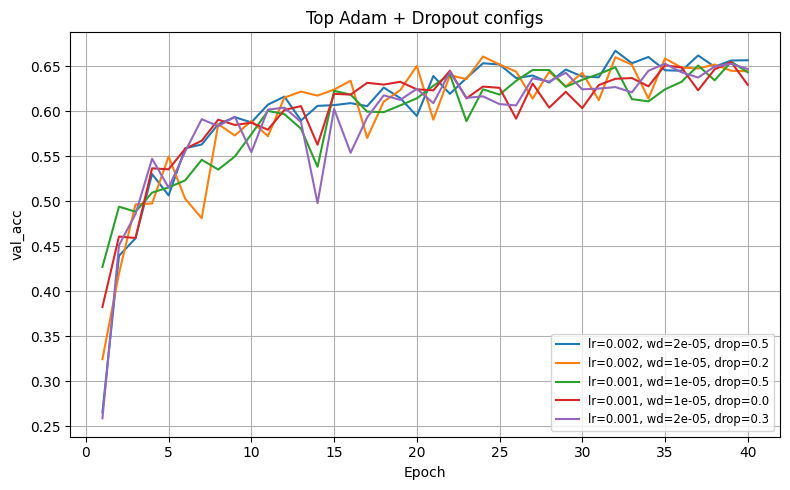

In [11]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adam_and_dropout_phrase_2(csv_path, quick=False)
    plot_best_histories_phrase_2(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


In [13]:
def tune_adam_and_dropout_phrase_3(csv_path: str, quick: bool = True):
    # lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    # wds = [0.0, 2e-5, 1e-5, 1e-4]
    # dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]
    lr_wd_dropout_combination = [
        {"lr": 2e-3, "wd": 2e-5, "dropout": 0.5},
        {"lr": 1.5 * 1e-3, "wd": 1.5 * 1e-5, "dropout": 0.45},
        {"lr": 1.7 * 1e-3, "wd": 1.8 * 1e-5, "dropout": 0.55},
        {"lr": 2.2 * 1e-3, "wd": 2.1 * 1e-5, "dropout": 0.35},
        
        {"lr": 2e-3, "wd": 1e-5, "dropout": 0.2},
        {"lr": 8 * 1e-4, "wd": 1.2 * 1e-5, "dropout": 0.22},
        {"lr": 9 * 1e-3, "wd": 1.3 * 1e-5, "dropout": 0.24},
        {"lr": 1.1 * 1e-3, "wd": 1 * 1e-5, "dropout": 0.18},
    ]

    num_epochs = 20 if quick else 60
    batch_size = 256

    all_results = []

    for combinations in lr_wd_dropout_combination:
        lr = combinations["lr"]
        wd = combinations["wd"]
        p = combinations["dropout"]
        exp_name = f"adam_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
        print("=" * 80)
        print(f"Running {exp_name}")
        res = run_adam_dropout_experiment(
            exp_name=exp_name,
            csv_path=csv_path,
            lr=lr,
            weight_decay=wd,
            dropout_p=p,
            num_epochs=num_epochs,
            batch_size=batch_size,
            quick=quick,
            verbose=True,
        )
        all_results.append(res)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_best_histories_phrase_3(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top Adam + Dropout configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Running adam_lr_0.002_weight_decay_2e-05_drop_out_0.5
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 1/60 | train loss 1.7005 acc 0.3090 | val loss 2.5474 acc 0.2594 | time 12.3s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 2/60 | train loss 1.4077 acc 0.4615 | val loss 1.3038 acc 0.5015 | time 12.0s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 3/60 | train loss 1.2722 acc 0.5153 | val loss 1.2410 acc 0.5227 | time 11.9s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 4/60 | train loss 1.2027 acc 0.5426 | val loss 1.3828 acc 0.4887 | time 12.0s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 5/60 | train loss 1.1627 acc 0.5584 | val loss 1.2978 acc 0.5029 | time 11.9s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 6/60 | train loss 1.1273 acc 0.5746 | val loss 1.5264 acc 0.4712 | time 12.0s
[adam_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 7/60 | train loss 1.0966 acc 0.5846 | val loss 1.4506 acc 0.4628 | time 11.9s
[adam_lr_0.002_weight_

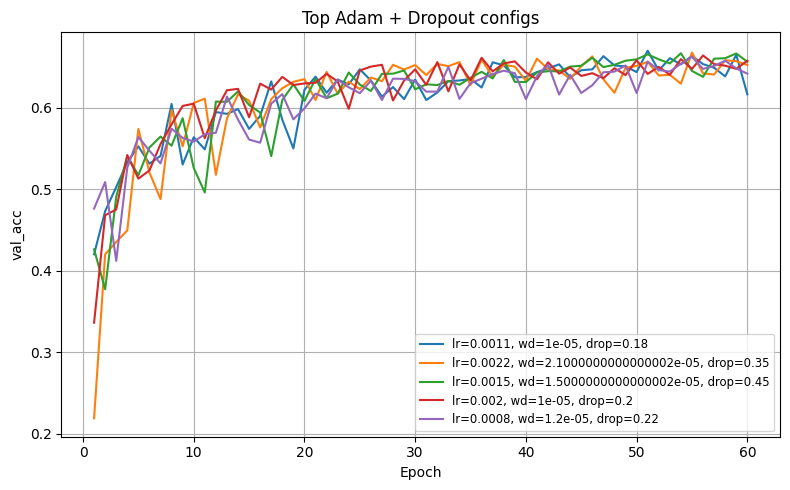

In [14]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adam_and_dropout_phrase_3(csv_path, quick=False)
    plot_best_histories_phrase_3(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


In [ ]:
def tune_adamw_and_dropout_phrase_1(csv_path: str, quick: bool = True):
    # lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    # wds = [0.0, 2e-5, 1e-5, 1e-4]
    # dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]
    lr_wd_dropout_combination = [
        {"lr": 2e-3, "wd": 2e-5, "dropout": 0.5},
        {"lr": 1.5 * 1e-3, "wd": 1.5 * 1e-5, "dropout": 0.45},
        {"lr": 1.7 * 1e-3, "wd": 1.8 * 1e-5, "dropout": 0.55},
        {"lr": 2.2 * 1e-3, "wd": 2.1 * 1e-5, "dropout": 0.35},
        
        {"lr": 2e-3, "wd": 1e-5, "dropout": 0.2},
        {"lr": 8 * 1e-4, "wd": 1.2 * 1e-5, "dropout": 0.22},
        {"lr": 1.1 * 1e-3, "wd": 1 * 1e-5, "dropout": 0.18},
        {"lr": 1.1 * 1e-3, "wd": 1.05 * 1e-5, "dropout": 0.185},
    ]

    num_epochs = 20 if quick else 60
    batch_size = 256

    all_results = []

    for combinations in lr_wd_dropout_combination:
        lr = combinations["lr"]
        wd = combinations["wd"]
        p = combinations["dropout"]
        exp_name = f"adamw_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
        print("=" * 80)
        print(f"Running {exp_name}")
        res = run_adamw_dropout_experiment(
            exp_name=exp_name,
            csv_path=csv_path,
            lr=lr,
            weight_decay=wd,
            dropout_p=p,
            num_epochs=num_epochs,
            batch_size=batch_size,
            quick=quick,
            verbose=True,
        )
        all_results.append(res)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_adamw_best_histories_phrase_1(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top AdamW + Dropout configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Running adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 1/60 | train loss 1.7314 acc 0.2923 | val loss 1.9096 acc 0.3087 | time 12.0s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 2/60 | train loss 1.4427 acc 0.4423 | val loss 1.4578 acc 0.4430 | time 12.0s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 3/60 | train loss 1.2967 acc 0.5066 | val loss 1.3540 acc 0.4687 | time 11.9s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 4/60 | train loss 1.2106 acc 0.5448 | val loss 1.2779 acc 0.5174 | time 11.9s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 5/60 | train loss 1.1664 acc 0.5575 | val loss 1.2269 acc 0.5428 | time 11.9s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 6/60 | train loss 1.1240 acc 0.5762 | val loss 1.4648 acc 0.5169 | time 12.0s
[adamw_lr_0.002_weight_decay_2e-05_drop_out_0.5] Epoch 7/60 | train loss 1.0949 acc 0.5874 | val loss 1.6478 acc 0.4274 | time 12.0s
[adamw_lr_0.00

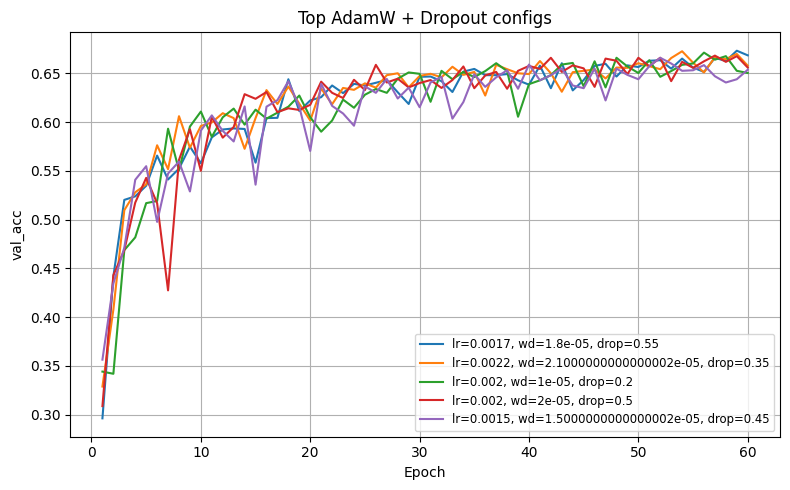

In [18]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adamw_and_dropout_phrase_1(csv_path, quick=False)
    plot_adamw_best_histories_phrase_1(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


In [7]:
def tune_adamw_and_dropout_phrase_2(csv_path: str, quick: bool = True):
    # lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    # wds = [0.0, 2e-5, 1e-5, 1e-4]
    # dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]
    lr_wd_dropout_combination = [
        {"lr": 1.7 * 1e-3, "wd": 1.8 * 1e-5, "dropout": 0.55},
        {"lr": 1.8 * 1e-3, "wd": 1.8 * 1e-5, "dropout": 0.55},
        {"lr": 1.9 * 1e-3, "wd": 1.9 * 1e-5, "dropout": 0.55},
        {"lr": 1.7 * 1e-3, "wd": 1.8 * 1e-5, "dropout": 0.54},
        {"lr": 1.85 * 1e-3, "wd": 1.83 * 1e-5, "dropout": 0.53},
        
        {"lr": 2.2 * 1e-3, "wd": 2.1 * 1e-5, "dropout": 0.35},
        {"lr": 2.17 * 1e-3, "wd": 2.08 * 1e-5, "dropout": 0.37},
        
        {"lr": 2e-3, "wd": 1e-5, "dropout": 0.2},
        
        {"lr": 2.1 * 1e-3, "wd": 1.05 * 1e-5, "dropout": 0.19},
        
        {"lr": 1.7 * 1e-3, "wd": 1.75 * 1e-5, "dropout": 0.56},
        
        {"lr": 1.2 * 1e-3, "wd": 2.4 * 1e-5, "dropout": 0.3},
    ]

    num_epochs = 20 if quick else 60
    batch_size = 256

    all_results = []

    for combinations in lr_wd_dropout_combination:
        lr = combinations["lr"]
        wd = combinations["wd"]
        p = combinations["dropout"]
        exp_name = f"adamw_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
        print("=" * 80)
        print(f"Running {exp_name}")
        res = run_adamw_dropout_experiment(
            exp_name=exp_name,
            csv_path=csv_path,
            lr=lr,
            weight_decay=wd,
            dropout_p=p,
            num_epochs=num_epochs,
            batch_size=batch_size,
            quick=quick,
            verbose=True,
        )
        all_results.append(res)
        time.sleep(240)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_adamw_best_histories_phrase_2(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top AdamW + Dropout configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Running adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 1/60 | train loss 1.7075 acc 0.3077 | val loss 1.7657 acc 0.3653 | time 12.6s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 2/60 | train loss 1.4033 acc 0.4592 | val loss 1.4468 acc 0.4464 | time 13.2s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 3/60 | train loss 1.2796 acc 0.5124 | val loss 1.4484 acc 0.4422 | time 12.6s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 4/60 | train loss 1.2146 acc 0.5422 | val loss 1.3300 acc 0.4790 | time 13.4s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 5/60 | train loss 1.1669 acc 0.5609 | val loss 1.2827 acc 0.5325 | time 13.3s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 6/60 | train loss 1.1258 acc 0.5729 | val loss 1.1695 acc 0.5639 | time 12.8s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 7/60 | train loss 1.0952 acc 0.5893 | val loss 1.0957 acc 0.

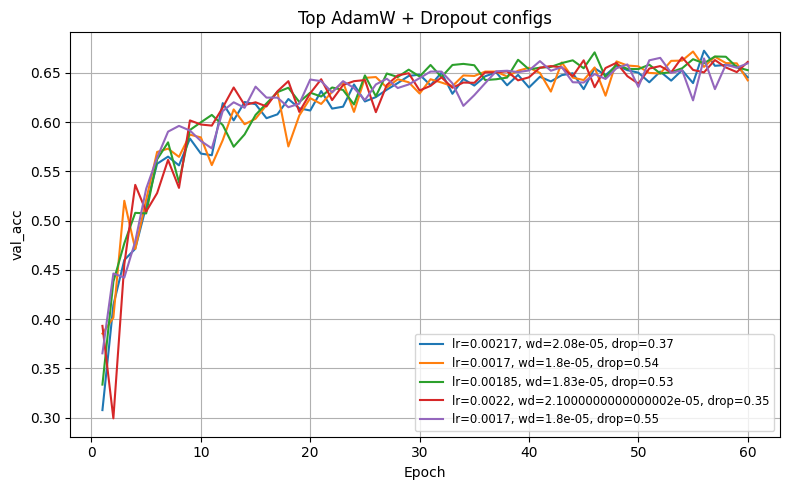

In [8]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adamw_and_dropout_phrase_2(csv_path, quick=False)
    plot_adamw_best_histories_phrase_2(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


# Using the best parameter from tuning phase

In [5]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"

    num_epochs   = 50
    batch_size   = 128
    lr           = 0.00217
    weight_decay = 2.08e-05
    dropout_p      = 0.37
    quick_debug  = False

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Scheduler
    # scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)

        # scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"time {time.time() - t0:.1f}s"
        )

    print(f"Best val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "final_fer2013_cnn_bn_adam_aug_dropout0_5.pth")
        print("Saved final model.")


Epoch 1/50 | train loss 1.7488 acc 0.2846 | val loss 1.6664 acc 0.3475 | time 13.0s
Epoch 2/50 | train loss 1.4693 acc 0.4274 | val loss 1.4276 acc 0.4564 | time 12.6s
Epoch 3/50 | train loss 1.3020 acc 0.5003 | val loss 1.3658 acc 0.4820 | time 13.8s
Epoch 4/50 | train loss 1.2260 acc 0.5345 | val loss 1.1954 acc 0.5364 | time 14.6s
Epoch 5/50 | train loss 1.1715 acc 0.5547 | val loss 1.2453 acc 0.5378 | time 13.5s
Epoch 6/50 | train loss 1.1299 acc 0.5732 | val loss 1.2152 acc 0.5205 | time 14.0s
Epoch 7/50 | train loss 1.0960 acc 0.5835 | val loss 1.1417 acc 0.5687 | time 14.4s
Epoch 8/50 | train loss 1.0702 acc 0.5932 | val loss 1.1173 acc 0.5812 | time 14.8s
Epoch 9/50 | train loss 1.0471 acc 0.6026 | val loss 1.1325 acc 0.5748 | time 14.3s
Epoch 10/50 | train loss 1.0218 acc 0.6177 | val loss 1.0733 acc 0.6043 | time 14.4s
Epoch 11/50 | train loss 1.0065 acc 0.6177 | val loss 1.0971 acc 0.6013 | time 12.7s
Epoch 12/50 | train loss 0.9940 acc 0.6252 | val loss 1.0647 acc 0.6074 | 

# Add scheduler

In [6]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"

    num_epochs   = 80
    batch_size   = 256
    lr           = 0.0017 # 1.7 * 1e-3
    weight_decay = 0.000018 # 1.8 * 1e-5
    dropout_p    = 0.55
    quick_debug  = False

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = optim.AdamW([
        {'params': model.block1.parameters(), 'lr': 0.001, 'weight_decay': 0.00001},
        {'params': model.block2.parameters(), 'lr': 0.0012, 'weight_decay': 0.000012},
        {'params': model.block3.parameters(), 'lr': 0.0015, 'weight_decay': 0.000015},
        {'params': model.block4.parameters(), 'lr': 0.0017, 'weight_decay': 0.000018},
        {'params': model.fc.parameters(), 'lr': 0.0019, 'weight_decay': 0.00002}
    ])

    # Scheduler
    # scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        patience=5,     # chờ 5 epoch không cải thiện
        factor=0.5,     # giảm LR còn một nửa
        threshold=5e-4, # tránh nhiễu nhỏ
        cooldown=2,     # nghỉ 2 epoch sau khi giảm
        min_lr=1e-6     # không giảm dưới 1e-6
    )

    best_val_acc = 0.0
    best_state = None
    UNFREEZE_EPOCH = 6
    FINE_TUNE_LR   = 5e-5

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        
        # if epoch == UNFREEZE_EPOCH:
        #     for i in range(4):
        #         optimizer.param_groups[i]['lr'] = FINE_TUNE_LR
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"time {time.time() - t0:.1f}s"
        )

    print(f"Best val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "final_fer2013.pth")
        print("Saved final model.")


Epoch 1/80 | train loss 1.7321 acc 0.2912 | val loss 1.6445 acc 0.3753 | time 14.4s
Epoch 2/80 | train loss 1.4459 acc 0.4419 | val loss 1.5656 acc 0.4296 | time 14.1s
Epoch 3/80 | train loss 1.3065 acc 0.5025 | val loss 1.4105 acc 0.4581 | time 14.2s
Epoch 4/80 | train loss 1.2245 acc 0.5370 | val loss 1.3924 acc 0.4614 | time 14.2s
Epoch 5/80 | train loss 1.1754 acc 0.5531 | val loss 1.4056 acc 0.4946 | time 14.4s
Epoch 6/80 | train loss 1.1362 acc 0.5701 | val loss 1.2205 acc 0.5542 | time 14.4s
Epoch 7/80 | train loss 1.1083 acc 0.5817 | val loss 1.1475 acc 0.5737 | time 14.1s
Epoch 8/80 | train loss 1.0778 acc 0.5927 | val loss 1.1425 acc 0.5804 | time 14.3s
Epoch 9/80 | train loss 1.0588 acc 0.6017 | val loss 1.0886 acc 0.5876 | time 14.3s
Epoch 10/80 | train loss 1.0374 acc 0.6094 | val loss 1.2654 acc 0.5486 | time 14.9s
Epoch 11/80 | train loss 1.0264 acc 0.6125 | val loss 1.1030 acc 0.5935 | time 14.9s
Epoch 12/80 | train loss 1.0081 acc 0.6216 | val loss 1.0745 acc 0.5974 | 

# Parameter Tuning With Scheduler

In [ ]:
def run_adamw_dropout_with_scheduler_experiment(
    exp_name: str,
    csv_path: str,
    lr: float,
    weight_decay: float,
    dropout_p: float,
    num_epochs: int = 30,
    batch_size: int = 256,
    quick: bool = False,
    verbose: bool = True,
):
    # dataloaders with augmentation ON
    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        patience=5,     # chờ 5 epoch không cải thiện
        factor=0.5,     # giảm LR còn một nửa
        threshold=1e-3, # tránh nhiễu nhỏ
        cooldown=2,     # nghỉ 2 epoch sau khi giảm
        min_lr=1e-6     # không giảm dưới 1e-6
    )

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

        scheduler.step(val_acc)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        if verbose:
            print(
                f"[{exp_name}] Epoch {epoch}/{num_epochs} | "
                f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
                f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
                f"time {time.time() - t0:.1f}s"
            )

    result = {
        "exp_name": exp_name,
        "lr": lr,
        "weight_decay": weight_decay,
        "dropout_p": dropout_p,
        "num_epochs": num_epochs,
        "best_val_acc": best_val_acc,
        "history": history,
    }

    if best_state is not None:
        model.load_state_dict(best_state)
        out_path = OUT_DIR / f"{exp_name}_best.pth"
        torch.save(model.state_dict(), out_path)

    return result


In [9]:
def tune_adamw_and_dropout_with_scheduler_phrase_1(csv_path: str, quick: bool = True):
    # lrs = [1e-4, 5e-4, 1e-3, 2e-3]
    # wds = [0.0, 2e-5, 1e-5, 1e-4]
    # dropouts = [0.0, 0.1, 0.2, 0.3, 0.5]
    lr_wd_dropout_combination = [
        {"lr": 0.0017, "wd": 0.000018, "dropout": 0.55},
        {"lr": 0.0022, "wd": 0.000022, "dropout": 0.35},
        {"lr": 0.002, "wd": 0.00001, "dropout": 0.2},
        {"lr": 0.00217, "wd": 0.0000208, "dropout": 0.37},
        {"lr": 0.0017, "wd": 0.000018, "dropout": 0.54}
    ]

    num_epochs = 20 if quick else 150
    batch_size = 256

    all_results = []

    for combinations in lr_wd_dropout_combination:
        lr = combinations["lr"]
        wd = combinations["wd"]
        p = combinations["dropout"]
        exp_name = f"adamw_lr_{lr}_weight_decay_{wd}_drop_out_{p}"
        print("=" * 80)
        print(f"Running {exp_name}")
        res = run_adamw_dropout_experiment(
            exp_name=exp_name,
            csv_path=csv_path,
            lr=lr,
            weight_decay=wd,
            dropout_p=p,
            num_epochs=num_epochs,
            batch_size=batch_size,
            quick=quick,
            verbose=True,
        )
        all_results.append(res)
        time.sleep(240)

    # sort by best_val_acc descending
    all_results.sort(key=lambda r: r["best_val_acc"], reverse=True)

    print("\nTop configurations:")
    for r in all_results[:]:
        print(
            f"{r['exp_name']}: "
            f"val_acc={r['best_val_acc']:.4f}, "
            f"lr={r['lr']}, wd={r['weight_decay']}, dropout={r['dropout_p']}"
        )

    return all_results

def plot_adamw_with_scheduler_best_histories_phrase_1(results, top_k=3):
    best = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)[:top_k]
    plt.figure(figsize=(8,5))
    for r in best:
        hist = r["history"]["val_acc"]
        epochs = range(1, len(hist)+1)
        label = f"lr={r['lr']}, wd={r['weight_decay']}, drop={r['dropout_p']}"
        plt.plot(epochs, hist, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("val_acc")
    plt.title("Top AdamW + Dropout + Scheduler configs")
    plt.legend(fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"  # adjust path

    # quick coarse search on subset
    results_quick = tune_adamw_and_dropout_with_scheduler_phrase_1(csv_path, quick=False)
    plot_adamw_with_scheduler_best_histories_phrase_1(results_quick, top_k=5)

    # after you see the best 2–3 configs, you can re-run them with quick=False
    # by manually calling run_adam_dropout_experiment for those specific settings


Running adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 1/150 | train loss 1.7085 acc 0.3075 | val loss 1.8339 acc 0.3444 | time 12.5s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 2/150 | train loss 1.4053 acc 0.4601 | val loss 1.5485 acc 0.4310 | time 13.7s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 3/150 | train loss 1.2792 acc 0.5134 | val loss 1.2336 acc 0.5341 | time 13.6s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 4/150 | train loss 1.2015 acc 0.5445 | val loss 1.3605 acc 0.5171 | time 13.7s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 5/150 | train loss 1.1565 acc 0.5621 | val loss 1.1669 acc 0.5497 | time 14.0s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 6/150 | train loss 1.1186 acc 0.5751 | val loss 1.2106 acc 0.5313 | time 13.7s
[adamw_lr_0.0017_weight_decay_1.8e-05_drop_out_0.55] Epoch 7/150 | train loss 1.0957 acc 0.5839 | val loss 1.2938

KeyboardInterrupt: 

# Using class weight to fix class imbalance

In [10]:
from torch.utils.data import Subset

def get_labels_from_dataset(ds):
    """Return a numpy array of labels from a Dataset or Subset.
    """
    # If it's a Subset, unwrap and index
    if isinstance(ds, Subset):
        base = ds.dataset
        idxs = ds.indices
        if hasattr(base, "y"):              # FER2013Dataset from CSV
            all_labels = np.array(base.y)
        elif hasattr(base, "targets"):      # ImageFolder
            all_labels = np.array(base.targets)
        else:
            raise TypeError("Dataset does not have y or targets attribute")
        return all_labels[idxs]

    # Normal (non-Subset) dataset
    if hasattr(ds, "y"):
        return np.array(ds.y)
    elif hasattr(ds, "targets"):
        return np.array(ds.targets)
    else:
        raise TypeError("Dataset does not have y or targets attribute")


In [13]:
if __name__ == "__main__":
    csv_path = "./fer2013.csv"

    num_epochs   = 50
    batch_size   = 128
    lr           = 0.0017 # 1.7 * 1e-3
    weight_decay = 0.000018 # 1.8 * 1e-5
    dropout_p    = 0.55
    quick_debug  = False

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)

    train_dataset = train_loader.dataset
    labels = get_labels_from_dataset(train_dataset)   # numpy array of shape [N]

    class_counts = np.bincount(labels, minlength=num_classes)
    class_weights = class_counts.sum() / (num_classes * class_counts)  # inverse frequency, mean ~ 1
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

    print("Class counts:", class_counts)
    print("Class weights:", class_weights)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Scheduler
    # scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        patience=5,     # chờ 5 epoch không cải thiện
        factor=0.5,     # giảm LR còn một nửa
        threshold=5e-4, # tránh nhiễu nhỏ
        cooldown=2,     # nghỉ 2 epoch sau khi giảm
        min_lr=1e-6     # không giảm dưới 1e-6
    )

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"time {time.time() - t0:.1f}s"
        )

    print(f"Best val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "cnn_fer2013_with_class_weight.pth")
        print("Saved final model.")


Class counts: [3995  436 4097 7215 4830 3171 4965]
Class weights: tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')
Epoch 1/50 | train loss 2.1224 acc 0.0811 | val loss 2.0455 acc 0.1468 | time 15.0s
Epoch 2/50 | train loss 1.9647 acc 0.2147 | val loss 1.9461 acc 0.4012 | time 14.8s
Epoch 3/50 | train loss 1.8269 acc 0.3577 | val loss 1.7384 acc 0.3892 | time 14.7s
Epoch 4/50 | train loss 1.7528 acc 0.4229 | val loss 1.7728 acc 0.4327 | time 14.3s
Epoch 5/50 | train loss 1.6989 acc 0.4634 | val loss 1.8042 acc 0.4806 | time 14.4s
Epoch 6/50 | train loss 1.6620 acc 0.4857 | val loss 1.7504 acc 0.4756 | time 14.4s
Epoch 7/50 | train loss 1.6375 acc 0.5003 | val loss 1.6462 acc 0.5121 | time 14.3s
Epoch 8/50 | train loss 1.6101 acc 0.5217 | val loss 1.6340 acc 0.4575 | time 14.0s
Epoch 9/50 | train loss 1.5941 acc 0.5308 | val loss 1.6398 acc 0.5188 | time 15.2s
Epoch 10/50 | train loss 1.5739 acc 0.5446 | val loss 1.5900 acc 0.5475 | time 14.7s
Epoc

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

def get_all_preds_labels(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)

y_true, y_pred = get_all_preds_labels(model, val_loader, DEVICE)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nPer-class accuracy:")
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for name, acc in zip(emotion_names, per_class_acc):
    print(f"{name:10s}: {acc:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=emotion_names))


Confusion matrix:
 [[291  27  23  12  53  13  48]
 [  6  42   1   1   4   1   1]
 [ 59  28 175  10 109  51  64]
 [ 18  18   9 756  20  25  49]
 [ 73  24  53  23 360  10 110]
 [ 13   3  18  15  10 346  10]
 [ 43  14  16  48  79   6 401]]

Per-class accuracy:
Angry     : 0.6231
Disgust   : 0.7500
Fear      : 0.3528
Happy     : 0.8447
Sad       : 0.5513
Surprise  : 0.8337
Neutral   : 0.6606

Classification report:
              precision    recall  f1-score   support

       Angry       0.58      0.62      0.60       467
     Disgust       0.27      0.75      0.40        56
        Fear       0.59      0.35      0.44       496
       Happy       0.87      0.84      0.86       895
         Sad       0.57      0.55      0.56       653
    Surprise       0.77      0.83      0.80       415
     Neutral       0.59      0.66      0.62       607

    accuracy                           0.66      3589
   macro avg       0.60      0.66      0.61      3589
weighted avg       0.67      0.66      0.66

# ResNet18

In [8]:
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def get_resnet18_fer(num_classes: int = 7, pretrained: bool = True, freeze_backbone: bool = True, dropout_rate = 0.0):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    in_features = model.fc.in_features
    if dropout_rate > 0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    else:
        model.fc = nn.Linear(in_features, num_classes)
        
    return model

def predict_with_tta(model, images):
    """Predicts using original image + horizontal flip"""
    logits = model(images)
    images_flipped = torch.flip(images, dims=[3])
    logits_flipped = model(images_flipped)
    return (logits + logits_flipped) / 2

def evaluate_resnet(model, loader, criterion, device, use_tta=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            
            if use_tta:
                outputs = predict_with_tta(model, images)
            else:
                outputs = model(images)
                
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    return running_loss / total, correct / total

def evaluate_detailed(model, loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_targets = []
    
    print("\n>>> Running detailed evaluation on Best Model...")
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            # Use TTA for final evaluation too
            outputs = predict_with_tta(model, images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
            
    # 1. Accuracy
    acc = accuracy_score(all_targets, all_preds)
    print(f"Final Test Accuracy: {acc:.4f}")
    
    # 2. Classification Report
    if class_names is None:
        class_names = [str(i) for i in range(7)]
        
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))
    
    # 3. Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Best Model)')
    plt.show()

Device: cuda
>>> Sampler active: Class Weights disabled in Loss to avoid double-correction.
Epoch 1/70 | Time: 131.4s | Train: 1.7537 (31.96%) | Val: 1.6511 (38.95%) | Best: 38.95% | LR: 1.0e-03/5.0e-10
Epoch 2/70 | Time: 74.5s | Train: 1.6658 (37.91%) | Val: 1.6361 (39.70%) | Best: 39.70% | LR: 1.0e-03/2.0e-09
Epoch 3/70 | Time: 73.0s | Train: 1.6483 (39.02%) | Val: 1.6103 (42.24%) | Best: 42.24% | LR: 1.0e-03/4.5e-09
Epoch 4/70 | Time: 76.5s | Train: 1.6381 (39.48%) | Val: 1.6027 (41.66%) | Best: 42.24% | LR: 9.9e-04/8.0e-09
Epoch 5/70 | Time: 127.6s | Train: 1.6369 (39.54%) | Val: 1.5851 (44.22%) | Best: 44.22% | LR: 9.9e-04/1.3e-08

>>> Unfreezing ResNet18 backbone...
>>> Backbone activated with LR: 5e-05
Epoch 6/70 | Time: 157.1s | Train: 1.4252 (51.70%) | Val: 1.2945 (58.74%) | Best: 58.74% | LR: 9.8e-04/5.0e-05
Epoch 7/70 | Time: 160.9s | Train: 1.2736 (59.67%) | Val: 1.2245 (61.77%) | Best: 61.77% | LR: 9.8e-04/4.9e-05
Epoch 8/70 | Time: 179.7s | Train: 1.2078 (63.32%) | Val: 1

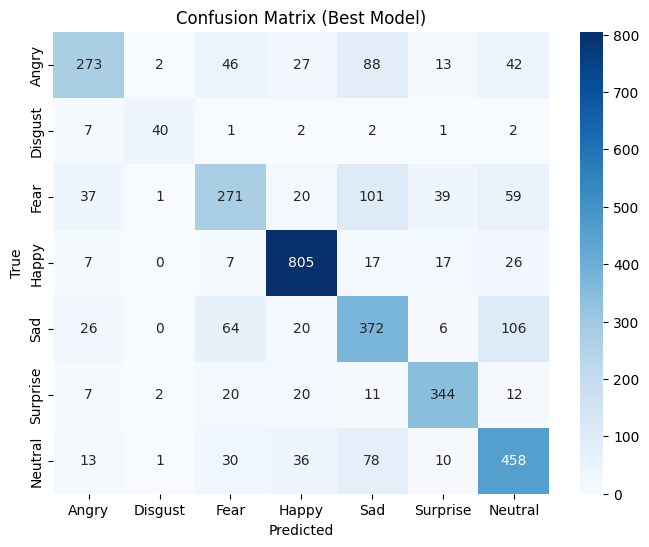

In [10]:
if __name__ == "__main__":
    # Settings
    csv_path     = "./fer2013.csv"
    DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    OUT_DIR      = Path(".")
    
    num_epochs   = 70
    batch_size   = 128
    lr           = 1e-3
    weight_decay = 1e-2
    quick_debug  = False
    use_sampler  = True
    dropout_rate = 0.0

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    print(f"Device: {DEVICE}")

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True, 
        for_transfer=True,
        # use_sampler=use_sampler
    )

    model = get_resnet18_fer(num_classes=num_classes, pretrained=True, freeze_backbone=True, dropout_rate=dropout_rate).to(DEVICE)

    criterion_weights = None
    if not use_sampler:
        train_dataset = train_loader.dataset
        labels = train_dataset.y if not quick_debug else train_dataset.dataset.y[train_dataset.indices]
        class_counts = np.bincount(labels, minlength=num_classes)
        class_weights = class_counts.sum() / (num_classes * class_counts)
        criterion_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
        print(">>> Using Class Weights in Loss function (No Sampler).")
    else:
        print(">>> Sampler active: Class Weights disabled in Loss to avoid double-correction.")

    criterion = nn.CrossEntropyLoss(weight=criterion_weights, label_smoothing=0.1)

    optimizer = optim.AdamW([
        {'params': model.fc.parameters(), 'lr': lr},            # Head
        {'params': list(model.parameters())[:-2], 'lr': 0.0}    # Backbone
    ], weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_acc = 0.0
    best_state = None
    UNFREEZE_EPOCH = 6
    FINE_TUNE_LR   = 5e-5

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()

        if epoch == UNFREEZE_EPOCH:
            print("\n>>> Unfreezing ResNet18 backbone...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer.param_groups[1]['lr'] = FINE_TUNE_LR
            print(f">>> Backbone activated with LR: {FINE_TUNE_LR}")

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, targets in train_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_resnet(model, val_loader, criterion, DEVICE, use_tta=True)

        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        dt = time.time() - t0
        lr_head = optimizer.param_groups[0]['lr']
        lr_back = optimizer.param_groups[1]['lr']
        
        print(f"Epoch {epoch}/{num_epochs} | "
              f"Time: {dt:.1f}s | "
              f"Train: {train_loss:.4f} ({train_acc:.2%}) | "
              f"Val: {val_loss:.4f} ({val_acc:.2%}) | "
              f"Best: {best_val_acc:.2%} | "
              f"LR: {lr_head:.1e}/{lr_back:.1e}")

    print(f"\nTraining Complete. Best Validation Accuracy: {best_val_acc:.4f}")
    print("\n" + "="*40)
    print("FINAL MODEL EVALUATION")
    print("="*40)
    
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "best_resnet18_fer.pth")
        print("Loaded best model state for evaluation.")
        
    evaluate_detailed(model, test_loader, DEVICE, class_names)

# Tuning ResNet

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import time
import copy

def get_resnet18_fer_tunable(num_classes=7, dropout_rate=0.0):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
    
    in_features = model.fc.in_features
    if dropout_rate > 0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    else:
        model.fc = nn.Linear(in_features, num_classes)
        
    return model

def run_training_session(config, train_loader, val_loader, device, epochs_per_run=15):
    print(f"\n--- Starting Experiment: {config['name']} ---")
    print(f"Config: {config}")

    model = get_resnet18_fer_tunable(num_classes=7, dropout_rate=config['dropout']).to(device)

    optimizer = optim.AdamW([
        {'params': model.fc.parameters(), 'lr': config['lr_head']},
        {'params': list(model.parameters())[:-2], 'lr': 0.0}
    ], weight_decay=config['weight_decay'])
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_per_run)
    
    best_acc = 0.0
    unfreeze_epoch = 4  

    for epoch in range(1, epochs_per_run + 1):
        if epoch == unfreeze_epoch:
            for param in model.parameters():
                param.requires_grad = True
            optimizer.param_groups[1]['lr'] = config['lr_backbone']

        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        _, val_acc = evaluate_resnet(model, val_loader, criterion, device, use_tta=True)
        scheduler.step()
        
        if val_acc > best_acc:
            best_acc = val_acc
            
        if epoch % 5 == 0:
            print(f"  Ep {epoch}: Val Acc {val_acc:.4f}")

    print(f"--> Result {config['name']}: Best Acc = {best_acc:.4f}")
    return best_acc

if __name__ == "__main__":
    csv_path = "./fer2013.csv"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name = 'FER2013',
        csv_path=csv_path, batch_size=128, quick=False, 
        use_augmentation=True, for_transfer=True
    )
    
    experiments = [
        {
            "name": "1. Aggressive",
            "lr_head": 1e-3,
            "lr_backbone": 5e-5,
            "weight_decay": 1e-2,
            "dropout": 0.0
        },
        {
            "name": "2. Gentle & Robust (Recommended)",
            "lr_head": 3e-4,
            "lr_backbone": 1e-5,
            "weight_decay": 1e-2,
            "dropout": 0.0
        },
        {
            "name": "3. High Regularization (If Overfitting)",
            "lr_head": 3e-4,
            "lr_backbone": 1e-6,
            "weight_decay": 5e-2, 
            "dropout": 0.4         
        }
    ]
    
    results = {}
    
    print(f"Starting Grid Search on {len(experiments)} configurations...")
    print("Running 15 epochs per config to find the most promising candidate.\n")
    
    for config in experiments:
        acc = run_training_session(
            config, 
            train_loader, 
            val_loader, 
            DEVICE, 
            epochs_per_run=15
        )
        results[config['name']] = acc
        

    print("\n" + "="*30)
    print("FINAL RESULTS")
    print("="*30)

    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    for name, acc in sorted_results:
        print(f"{name}: {acc:.4f}")
        
    print(f"\nRecommended Next Step: Take the parameters from '{sorted_results[0][0]}' "
          f"and train for 50-100 epochs.")

Starting Grid Search on 3 configurations...
Running 15 epochs per config to find the most promising candidate.


--- Starting Experiment: 1. Aggressive ---
Config: {'name': '1. Aggressive', 'lr_head': 0.001, 'lr_backbone': 5e-05, 'weight_decay': 0.01, 'dropout': 0.0}
  Ep 5: Val Acc 0.6222
  Ep 10: Val Acc 0.6670
  Ep 15: Val Acc 0.6790
--> Result 1. Aggressive: Best Acc = 0.6801

--- Starting Experiment: 2. Gentle & Robust (Recommended) ---
Config: {'name': '2. Gentle & Robust (Recommended)', 'lr_head': 0.0003, 'lr_backbone': 1e-05, 'weight_decay': 0.01, 'dropout': 0.0}
  Ep 5: Val Acc 0.5469
  Ep 10: Val Acc 0.5963
  Ep 15: Val Acc 0.6155
--> Result 2. Gentle & Robust (Recommended): Best Acc = 0.6155

--- Starting Experiment: 3. High Regularization (If Overfitting) ---
Config: {'name': '3. High Regularization (If Overfitting)', 'lr_head': 0.0003, 'lr_backbone': 1e-06, 'weight_decay': 0.05, 'dropout': 0.4}
  Ep 5: Val Acc 0.4115
  Ep 10: Val Acc 0.4784
  Ep 15: Val Acc 0.4873
--> Resu

# FINAL

Epoch 1/80 | train loss 1.7066 acc 0.3075 | val loss 1.6749 acc 0.3931 | time 14.9s
Epoch 2/80 | train loss 1.4060 acc 0.4616 | val loss 1.4302 acc 0.4363 | time 16.5s
Epoch 3/80 | train loss 1.2845 acc 0.5088 | val loss 1.3932 acc 0.4753 | time 25.2s
Epoch 4/80 | train loss 1.2101 acc 0.5394 | val loss 1.2016 acc 0.5489 | time 26.3s
Epoch 5/80 | train loss 1.1619 acc 0.5610 | val loss 1.2431 acc 0.5355 | time 25.9s
Epoch 6/80 | train loss 1.1331 acc 0.5707 | val loss 1.1845 acc 0.5598 | time 26.2s
Epoch 7/80 | train loss 1.0933 acc 0.5894 | val loss 1.1860 acc 0.5645 | time 25.9s
Epoch 8/80 | train loss 1.0717 acc 0.5973 | val loss 1.2198 acc 0.5467 | time 22.6s
Epoch 9/80 | train loss 1.0487 acc 0.6067 | val loss 1.1091 acc 0.5762 | time 24.2s
Epoch 10/80 | train loss 1.0323 acc 0.6104 | val loss 1.1409 acc 0.5821 | time 24.6s
Epoch 11/80 | train loss 1.0157 acc 0.6192 | val loss 1.1735 acc 0.5812 | time 24.9s
Epoch 12/80 | train loss 1.0076 acc 0.6217 | val loss 1.0526 acc 0.6163 | 

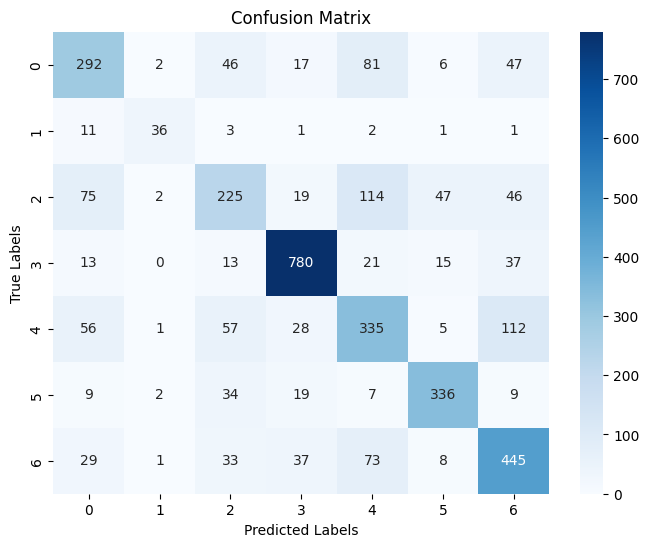

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

if __name__ == "__main__":
    csv_path = "./fer2013.csv"

    num_epochs   = 80
    batch_size   = 256
    lr           = 0.0017 # 1.7 * 1e-3
    weight_decay = 0.000018 # 1.8 * 1e-5
    dropout_p    = 0.55
    quick_debug  = False

    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        dataset_name="FER2013",
        csv_path=csv_path,
        batch_size=batch_size,
        quick=quick_debug,
        use_augmentation=True,
    )

    model = FinalFER2013CNN(num_classes=num_classes, dropout_p=dropout_p).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.AdamW([
    #     {'params': model.block1.parameters(), 'lr': 0.001, 'weight_decay': 0.00001},
    #     {'params': model.block2.parameters(), 'lr': 0.0012, 'weight_decay': 0.000012},
    #     {'params': model.block3.parameters(), 'lr': 0.0015, 'weight_decay': 0.000015},
    #     {'params': model.block4.parameters(), 'lr': 0.0017, 'weight_decay': 0.000018},
    #     {'params': model.fc.parameters(), 'lr': 0.0019, 'weight_decay': 0.00002}
    # ])

    # Scheduler
    # scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        patience=5,     # chờ 5 epoch không cải thiện
        factor=0.5,     # giảm LR còn một nửa
        threshold=5e-4, # tránh nhiễu nhỏ
        cooldown=2,     # nghỉ 2 epoch sau khi giảm
        min_lr=1e-6     # không giảm dưới 1e-6
    )

    best_val_acc = 0.0
    best_state = None
    UNFREEZE_EPOCH = 6
    FINE_TUNE_LR   = 5e-5

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        
        # if epoch == UNFREEZE_EPOCH:
        #     for i in range(4):
        #         optimizer.param_groups[i]['lr'] = FINE_TUNE_LR
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE)

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
            f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
            f"time {time.time() - t0:.1f}s"
        )

    print(f"Best val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), OUT_DIR / "final_fer2013.pth")
        print("Saved final model.")

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:   # hoặc test_loader nếu bạn có
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            preds = torch.argmax(out, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    # Sau khi collect all_preds và all_labels
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4, zero_division=0))

    # Vẽ confusion matrix với nhãn 7 lớp
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluation

### CNN Evaluation

Accuracy: 0.6823627751462803

Classification Report:
               precision    recall  f1-score   support

           0     0.6021    0.5947    0.5984       491
           1     0.8182    0.6545    0.7273        55
           2     0.5474    0.4261    0.4792       528
           3     0.8657    0.8874    0.8764       879
           4     0.5292    0.5640    0.5460       594
           5     0.8038    0.8077    0.8058       416
           6     0.6385    0.7109    0.6727       626

    accuracy                         0.6824      3589
   macro avg     0.6864    0.6636    0.6723      3589
weighted avg     0.6796    0.6824    0.6793      3589


Per-class accuracy:
Angry     : 0.5947
Disgust   : 0.6545
Fear      : 0.4261
Happy     : 0.8874
Sad       : 0.5640
Surprise  : 0.8077
Neutral   : 0.7109


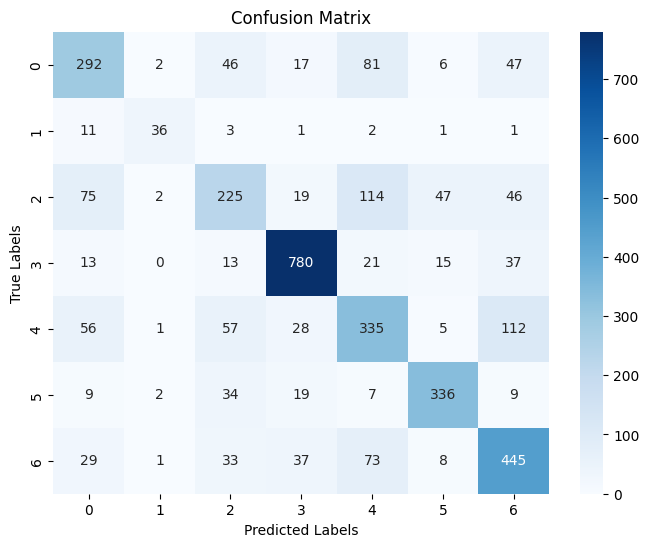

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cnn_state_dict_url = "https://raw.githubusercontent.com/ImmortalZeus/IT3320E_IntroductionToDeepLearning_Group4/refs/heads/main/Models/final_fer2013.pth"

model = FinalFER2013CNN(num_classes=7, dropout_p=0.55).to(DEVICE)
state_dict = torch.hub.load_state_dict_from_url(cnn_state_dict_url, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []

csv_path = "./fer2013.csv"
num_epochs   = 80
batch_size   = 256
quick_debug  = False

train_loader, val_loader, test_loader, num_classes = get_dataloaders(
    dataset_name="FER2013",
    csv_path=csv_path,
    batch_size=batch_size,
    quick=quick_debug,
    use_augmentation=True,
)

with torch.no_grad():
    for xb, yb in test_loader:   # hoặc test_loader nếu bạn có
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        preds = torch.argmax(out, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Sau khi collect all_preds và all_labels
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4, zero_division=0))

print("\nPer-class accuracy:")
per_class_acc = cm.diagonal() / cm.sum(axis=1)

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

for name, acc in zip(emotion_names, per_class_acc):
    print(f"{name:10s}: {acc:.4f}")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ResNet Evaluation

Accuracy: 0.7141264976316523

Classification Report:
               precision    recall  f1-score   support

           0     0.7378    0.5560    0.6341       491
           1     0.8696    0.7273    0.7921        55
           2     0.6173    0.5133    0.5605       528
           3     0.8656    0.9158    0.8900       879
           4     0.5561    0.6263    0.5891       594
           5     0.8000    0.8269    0.8132       416
           6     0.6496    0.7316    0.6882       626

    accuracy                         0.7141      3589
   macro avg     0.7280    0.6996    0.7096      3589
weighted avg     0.7152    0.7141    0.7111      3589


Per-class accuracy:
Angry     : 0.5560
Disgust   : 0.7273
Fear      : 0.5133
Happy     : 0.9158
Sad       : 0.6263
Surprise  : 0.8269
Neutral   : 0.7316


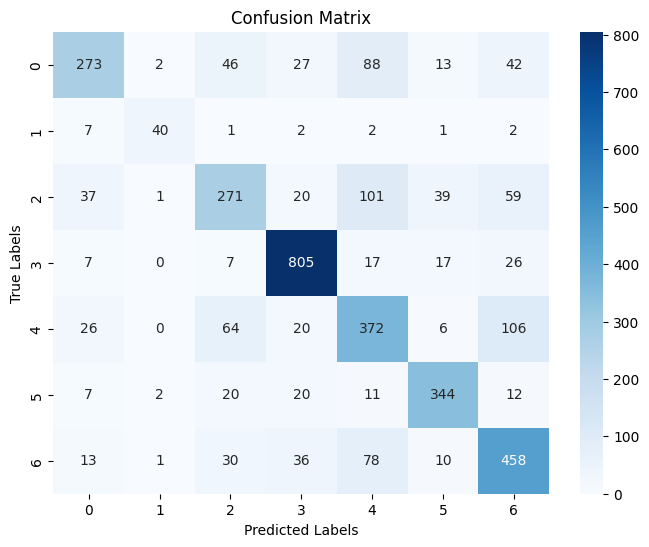

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
resnet_state_dict_url = "https://raw.githubusercontent.com/ImmortalZeus/IT3320E_IntroductionToDeepLearning_Group4/refs/heads/main/Models/best_resnet18_fer.pth"

def get_resnet18_fer(num_classes: int = 7, pretrained: bool = True, freeze_backbone: bool = True, dropout_rate = 0.0):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    in_features = model.fc.in_features
    if dropout_rate > 0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    else:
        model.fc = nn.Linear(in_features, num_classes)
        
    return model

def predict_with_tta(model, images):
    """Predicts using original image + horizontal flip"""
    logits = model(images)
    images_flipped = torch.flip(images, dims=[3])
    logits_flipped = model(images_flipped)
    return (logits + logits_flipped) / 2

model = get_resnet18_fer(num_classes=7, pretrained=True, freeze_backbone=True, dropout_rate=0.0).to(DEVICE)
state_dict = torch.hub.load_state_dict_from_url(resnet_state_dict_url, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

all_preds, all_labels = [], []

csv_path = "./fer2013.csv"
num_epochs   = 80
batch_size   = 256
quick_debug  = False

train_loader, val_loader, test_loader, num_classes = get_dataloaders(
    dataset_name="FER2013",
    csv_path=csv_path,
    batch_size=batch_size,
    quick=quick_debug,
    use_augmentation=True,
    for_transfer=True,
)

with torch.no_grad():
    for xb, yb in test_loader:   # hoặc test_loader nếu bạn có
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = predict_with_tta(model, xb)
        
        _, predicted = out.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Sau khi collect all_preds và all_labels
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, digits=4, zero_division=0))

print("\nPer-class accuracy:")
per_class_acc = cm.diagonal() / cm.sum(axis=1)

emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

for name, acc in zip(emotion_names, per_class_acc):
    print(f"{name:10s}: {acc:.4f}")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()